# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

В качестве метрики качества используем MAE.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People.
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.
Будем извлекать данные из папки с помощью метода ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

## Исследовательский анализ данных

Проведем исследовательский анализ данных:

- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка данных из CSV-файла
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Создание генератора данных на основе dataframe
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


In [4]:
# Посмотрим на размер выборки
print("Размер выборки:", len(labels))

Размер выборки: 7591


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


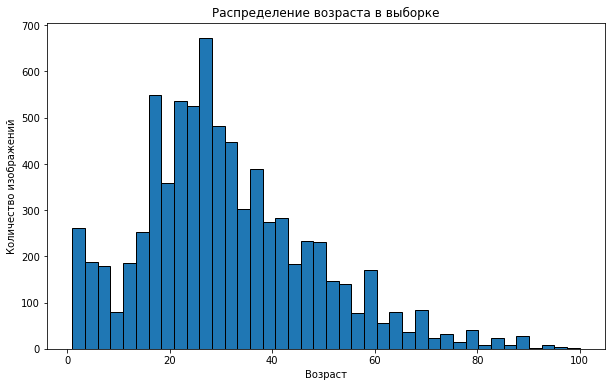

In [7]:
# Построим график распределения возраста в выборке
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=40, edgecolor='black')
plt.title("Распределение возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество изображений")
plt.show()

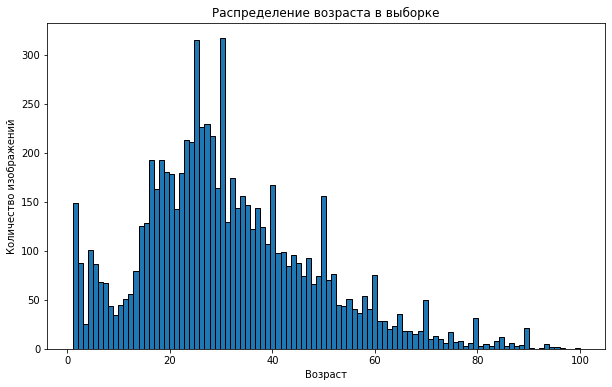

In [8]:
# РЕВЬЮЕР: Поиграемся с числом корзин
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title("Распределение возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество изображений")
plt.show()

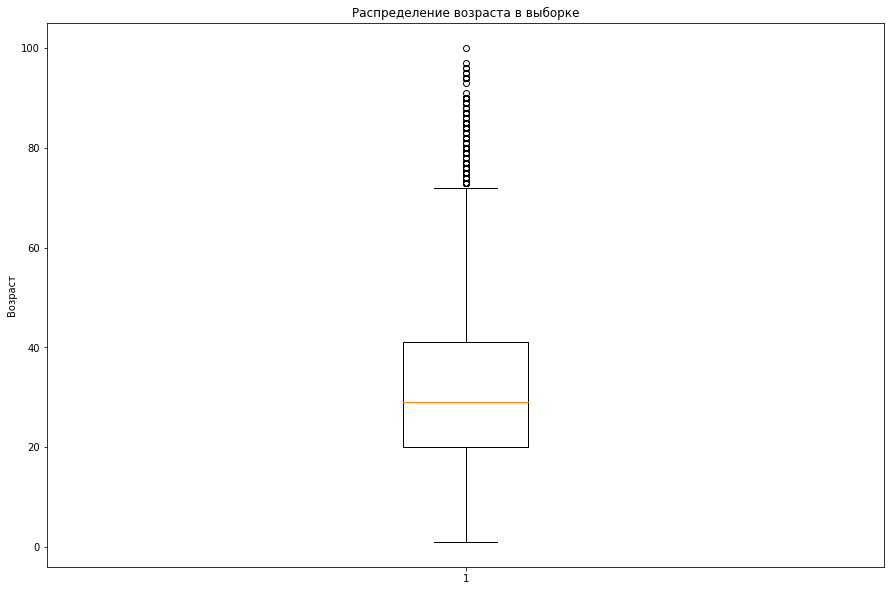

In [9]:
plt.figure(figsize=(15, 10))
plt.boxplot(x=labels['real_age'])
plt.title('Распределение возраста в выборке')
plt.ylabel('Возраст')
plt.show()

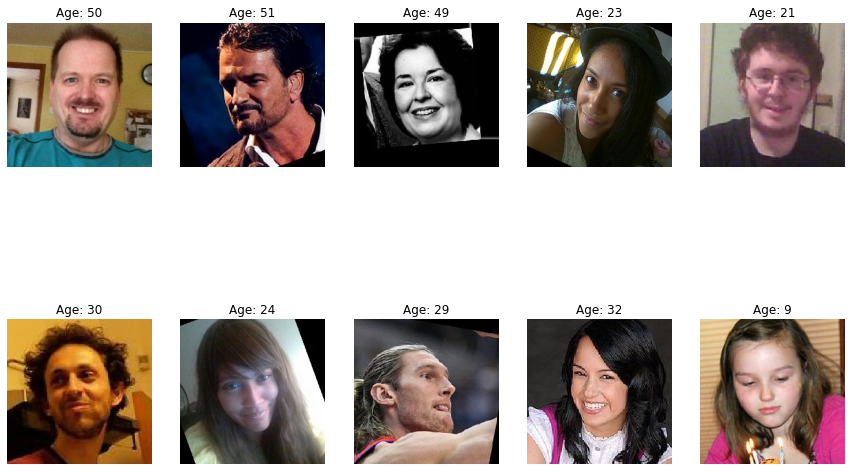

In [10]:
# Выведем на экран 10-15 фотографий
plt.figure(figsize=(15, 10))
for i in range(10):
    batch = next(train_gen_flow)
    image = batch[0][0]
    age = batch[1][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Age: {age}")
    plt.axis('off')
plt.show()

**Выводы**

- Имеются размеченые данные, где фотографии строго соотвествует метка возраста
- Построено распределение данных по возрастам с помощью гистограммы и boxplot, выбросы находятся за пределами верхней границы, статистически значимая часть выборки распределена нормально.
- Имеются совершенно различные изображения: черно-белые, повернутые, затемненные, с посторонними предметами, не в анфас и т.д. Этот датасет хорошо подойдет для задачи распознавания лиц на кассе, модель сможет обучиться распознавать лица при различном освещении и под разным углом.

## Обучение модели

Обучим модель в GPU-тренажёре и сохраним результат вывода модели на экран.

Будем использовать нейросеть архитектуры ResNet50.

Для работы с моделью используем следующие функции:

- load_train - загрузка и разделение данных на обучающие и тестовые выборки. Чтобы не перегрузить оперативную память используем загрузчик ImageDataGenerator, который будет делить данные на батчи по 32


- load_test - загрузка данных тестовой выборки, параметр seed должен совпадать


- create_model - создание модели, определение слоев, компиляция


- train model - запуск модели. Для достижения требуемого MAE 10 эпох будет достаточно

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',  
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw', 
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))  

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, shuffle=True)

    return model
```

```

# < скопируем результат вывода на экран сюда >


Using TensorFlow backend. Found 5314 validated image filenames. Found 2277 validated image filenames.

Train for 167 steps, validate for 72 steps Epoch 1/10

167/167 - 58s - loss: 11.4749 - mae: 11.4724 - val_loss: 22.0014 - val_mae: 22.0320 Epoch 2/10 167/167 - 52s - loss: 7.1215 - mae: 7.1146 - val_loss: 12.9231 - val_mae: 12.9223 Epoch 3/10 167/167 - 46s - loss: 5.7515 - mae: 5.7420 - val_loss: 14.4756 - val_mae: 14.4935 Epoch 4/10 167/167 - 46s - loss: 4.9836 - mae: 4.9812 - val_loss: 8.7153 - val_mae: 8.6912 Epoch 5/10 167/167 - 52s - loss: 4.3833 - mae: 4.3754 - val_loss: 7.6649 - val_mae: 7.6462 Epoch 6/10 167/167 - 48s - loss: 4.1087 - mae: 4.0554 - val_loss: 6.4172 - val_mae: 6.4227 Epoch 7/10 167/167 - 43s - loss: 3.5999 - mae: 3.5918 - val_loss: 6.3802 - val_mae: 6.4048 Epoch 8/10 167/167 - 42s - loss: 3.3494 - mae: 3.3263 - val_loss: 6.5823 - val_mae: 6.5896 Epoch 9/10 167/167 - 39s - loss: 3.0838 - mae: 3.0761 - val_loss: 8.1080 - val_mae: 8.1112 Epoch 10/10 167/167 - 39s - loss: 2.8240 - mae: 2.8114 - val_loss: 6.1070 - val_mae: 6.1125

72/72 - 12s - loss: 6.1070 - mae: 6.1125 Test MAE: 6.1125
```

## Анализ обученной модели

- Обучена сверточная нейросеть на датасете с фотографиями людей:
- Архитектура ResNet50, определено необходимое количество эпох
- Использованы предобученные веса
- Размер батча - 32
- Получен результат MAE 6,1, что соотвествует условиям. Модель не переобучена. Модель можно будет использовать для предсказания возраста покупателей